### Reconstruct distance maps

In [1]:
import torch
from torch import nn
import distance_heatmap
from distance_heatmap.distance_heatmap import Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# Source flattened distance map (example)
source1 = '/media/the_beast/A/mathisi_tests/data/transformed/fully_connected/6a02_labels.pickle'

In [3]:
with open(source1, 'rb') as labels_file:
    df1 = pickle.load(labels_file)
print(df1)
print(df1.shape)

tensor([0.0122, 0.0228, 0.0321,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
torch.Size([44850])


In [4]:
# Remove the padding that was given during data processing

non_zero = []
non_zero.clear()
for i in df1:
    if i == 0:
        pass
    else:
        non_zero.append(i)

non_zeroed = torch.tensor(non_zero, dtype=torch.float64)
print(non_zeroed)
print(non_zeroed.shape)

tensor([0.0122, 0.0228, 0.0321,  ..., 0.0122, 0.0196, 0.0121],
       dtype=torch.float64)
torch.Size([14365])


In [5]:
# Function to calculate the value of n, being the original size of the protein & n x n dimensions of the original distance matrix
# I hope you like the name
cache = {}
def golden_triangle(n):   
    if n in cache:
        return cache[n]  
    if n == 4:
        value = 6
    elif n == 5:
        value = 10
    elif n == 6:
        value = 15
    elif n > 6:
        value = golden_triangle(n-1) + n - 1        
    cache[n] = value
    
    return value

In [6]:
# Stupid manul part to identify the value of n by "trial & error" - yes, I am ashamed

x = golden_triangle(170)
print(non_zeroed.shape[0] - x)

0


In [7]:
# Once you have the value of n, set the variable span to this value
# This code will tag the flattened matrix at what should be the non zero entries. In the next step, the non zero
# entries will be populated by the values from the model output (or test flattened dstance matrix in this example)
span = 170
holder = torch.flatten(torch.zeros(span, span)) # Create an empty matrix & flatten, of the correct dimension of n
counter = 0
while counter <= span:
    for s in range(int(span**2 / 4)):
        s = s + span * counter
        if s == holder.shape[0]:
            break
        if s % span == 0:
            holder[s] = 0
        elif s % span <= counter:
            holder[s] = 0
        else:
            try:
                holder[s] = 5
            except:
                pass
    s += 1
    counter += 1


print(holder)
print(holder.shape)

tensor([0., 5., 5.,  ..., 0., 0., 0.])
torch.Size([28900])


In [8]:
# Replaces the non zero entries of the flattened matrix that will reconsitute the distance matrix using the
# values from the model output

counter_2 = 0
for num in range(holder.shape[0]):
    if holder[num] == 5:
        holder[num] = non_zeroed[counter_2]
        counter_2 += 1
print(holder)
print(holder.shape)

tensor([0.0000, 0.0122, 0.0228,  ..., 0.0000, 0.0000, 0.0000])
torch.Size([28900])


In [9]:
# Reconstitute the distance matrix

unflattened = torch.reshape(holder, (span, span))
triangle = unflattened.T
matrix = unflattened + triangle
matrix

tensor([[0.0000, 0.0122, 0.0228,  ..., 0.0552, 0.0595, 0.0541],
        [0.0122, 0.0000, 0.0121,  ..., 0.0446, 0.0479, 0.0424],
        [0.0228, 0.0121, 0.0000,  ..., 0.0330, 0.0372, 0.0336],
        ...,
        [0.0552, 0.0446, 0.0330,  ..., 0.0000, 0.0122, 0.0196],
        [0.0595, 0.0479, 0.0372,  ..., 0.0122, 0.0000, 0.0121],
        [0.0541, 0.0424, 0.0336,  ..., 0.0196, 0.0121, 0.0000]])

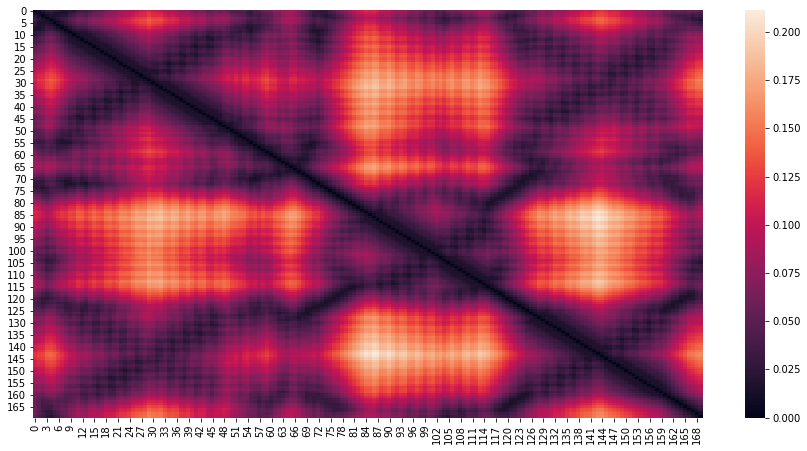

In [10]:
# Plot the heatmap of the reconsituted distance matrix

plt.figure(figsize = (15,7.5))
ax = sns.heatmap(matrix)
plt.show()

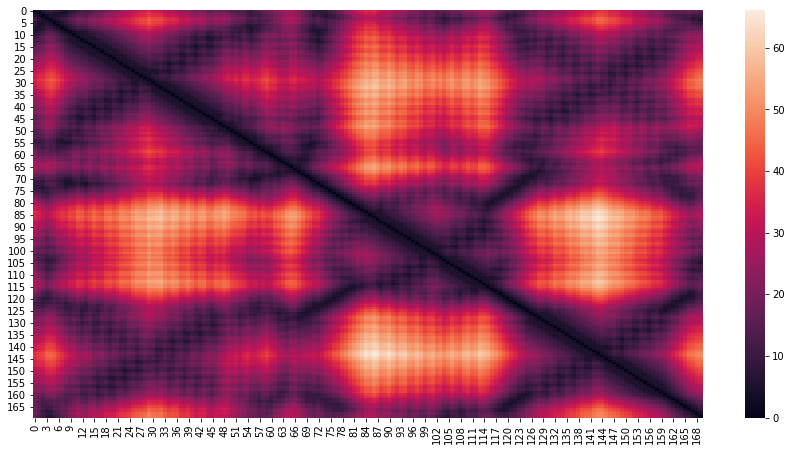

In [11]:
# Plot the heatmap of the original distance matrix (before data processing)

source2 = '/media/the_beast/A/mathisi_tests/data/transformed/distance_matrix/6a02_label.pickle'
heat = Heatmap(source2)
heat.loader()
heat.make_distance_map()

In [12]:
# Compare shapes

with open(source2, 'rb') as labels_file:
    df2 = pickle.load(labels_file)
print(df2.shape)
print(matrix.shape)

torch.Size([170, 170])
torch.Size([170, 170])
